In [260]:
"""
import modules
"""
from prepare_data import prepare_df_from_mac as prepare_data
from emulate_reduction import emulator_v2 as emulate
from visualize_output import vis_emulator_v2 as v2_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

dir(emulate)

['CtaxRedEmulator',
 'LinearRegression',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'combi_df',
 'df_11_SSP1',
 'df_11_SSP1_cubic',
 'df_11_SSP1_cubicroot',
 'df_11_SSP1_test',
 'math',
 'minimize',
 'np',
 'pd',
 'plt']

In [107]:
"""
load data
"""

df_linear = pd.read_table('C:/Users/toonv/Documents/PBL/Data/cost curves/costcurve_co2_linear.dat',
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table('C:/Users/toonv/Documents/PBL/Data/cost curves/costcurve_co2_cubic.dat',
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table('C:/Users/toonv/Documents/PBL/Data/cost curves/costcurve_co2_cubicroot.dat',
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

In [199]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.

"""

YEAR = 2050
REGION = 11
STEPSIZE_CTAX_PATH = 1  # stepsize the ctax path consists of so if 2 than 2,4,6...  


In [262]:
"""
prepare data using prepare_df

input: MAC sets (df), YEAR, REGION, STEPSIZE

output: ctax paths with reduction
"""

reload(prepare_data)

lin_reduction = prepare_data.reduction_df(df_linear, YEAR, REGION)
cubic_reduction = prepare_data.reduction_df(df_cubic, YEAR, REGION)
root_reduction = prepare_data.reduction_df(df_cubicroot, YEAR, REGION)

lin_paths = prepare_data.find_path(lin_reduction, STEPSIZE_CTAX_PATH, 'linear')
cubic_paths = prepare_data.find_path(cubic_reduction, STEPSIZE_CTAX_PATH, 'cubic')
root_paths = prepare_data.find_path(root_reduction, STEPSIZE_CTAX_PATH, 'cubicroot')

root_paths.tail()

,0,1,2,3,4,5,6,7,8,9,10,reduction
196,0.0,1819.502823,2292.429907,2624.177164,2888.280695,3111.306062,3306.256048,3480.583687,3639.005646,3784.718388,3920.0,89.5883
197,0.0,1828.786000,2304.125978,2637.565823,2903.016821,3127.180072,3323.124701,3498.341767,3657.572001,3804.028175,3940.0,89.6167
198,0.0,1838.069178,2315.822049,2650.954482,2917.752947,3143.054083,3339.993355,3516.099847,3676.138356,3823.337963,3960.0,89.6401
199,0.0,1847.352356,2327.518120,2664.343141,2932.489073,3158.928093,3356.862008,3533.857927,3694.704712,3842.647751,3980.0,89.6573
200,0.0,1856.635533,2339.214191,2677.731800,2947.225199,3174.802104,3373.730661,3551.616007,3713.271067,3861.957538,4000.0,89.6721


           b1         b2  ctax
0         NaN        NaN   200
1   33.753638 -58.746325   400
2   62.354128 -84.648555   600
3   38.965075 -56.150706   800
4    3.401222 -20.930137  1000
5  -11.890149  -6.427776  1200
6  -21.242424   0.948363  1400
7  -17.056310  -3.797898  1600
8  -16.283196  -7.523259  1800
9  -14.877190  -7.342678  2000
10  -8.715898  -7.770082  2200
11  -6.023066  -6.593898  2400
12  -1.506784  -8.379561  2600
13  -1.697549  -8.297586  2800
14  -2.992819  -8.637371  3000
15  -4.799569  -8.808414  3200
16  -6.758229  -8.380464  3400
17   2.516385 -16.039408  3600
18  13.481474 -24.890706  3800
19  14.975255 -26.273557  4000


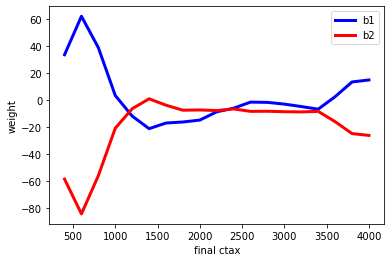

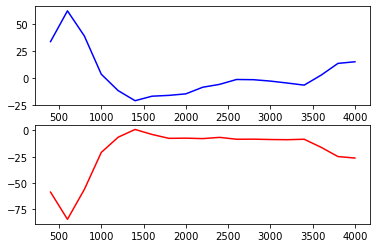

In [243]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

# only for this emulator we use combination of paths tot train and test
combi_paths = emulate.combi_df(cubic_paths, root_paths, cubic_reduction, root_reduction)

x = emulate.CtaxRedEmulator(lin_paths, combi_paths)

x.train_ctax_path()

# do it for all remaining test paths
cubic_test = []
root_test = []
    
for i in range(1, len(root_paths), 2):
        
    cubic_test.append(x.test_ctax_path(root_paths.loc[i]))
    root_test.append(x.test_ctax_path(cubic_paths.loc[i+1]))



In [227]:
root_paths.head()

,0,1,2,3,4,5,6,7,8,9,10,reduction
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0000
1,0.0,9.283178,11.696071,13.388659,14.736126,15.874011,16.868653,17.75808,18.566355,19.309788,20.0,22.4967
2,0.0,18.566355,23.392142,26.777318,29.472252,31.748021,33.737307,35.51616,37.132711,38.619575,40.0,24.5504
3,0.0,27.849533,35.088213,40.165977,44.208378,47.622032,50.605960,53.27424,55.699066,57.929363,60.0,26.8447
4,0.0,37.132711,46.784284,53.554636,58.944504,63.496042,67.474613,71.03232,74.265421,77.239151,80.0,28.8845


NameError: name 'plt' is not defined

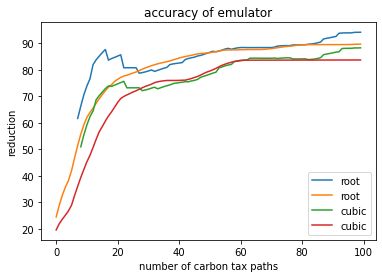

In [263]:
"""
Figures showing the emulated reduction vs real reduction

Also calculation of MSE
"""

reload(v2_plot)

reds = [i for i in range(len(cubic_test))]

for red in zip(*root_test):
    plt.plot(reds, red, label='root')
plt.title('accuracy of emulator')
plt.xlabel('number of carbon tax paths')
plt.ylabel('reduction')

for red in zip(*cubic_test):
    plt.plot(reds, red, label='cubic')

plt.legend()

reload(v2_plot)

v2_plot.emulator_v2_graphs(cubic_test, root_test)

In [266]:
x = np.array([0,1 ,2 ,3, 4])

y = x**3

y

y = 200* x**3/x[-1]**3

y

array([  0.   ,   3.125,  25.   ,  84.375, 200.   ])